In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
#device setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set up seed for consistency
torch.manual_seed(1)

# Define hyperparameters
learning_rate = 2e-4  # Learning rate for the optimizer
batch_size = 128  # Number of samples per batch
image_size = 64  # Size of the images (64x64)
image_channels = 3  # Number of channels in the images (3 for RGB)
noise_dimension = 100  # Dimension of the noise vector for the generator
epochs = 25  # Number of training epochs
discriminator_features = 64  # Number of features in the discriminator
generator_features = 64  # Number of features in the generator
adam_beta = 0.5  # Beta parameter for the Adam optimizer

# Define number of workers for data loading
workers = 2

# Define transformations for the training data
# Resize to image_size, convert to tensor, and normalize to [-1, 1]
transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]
        ),
    ]
)

# Load the CIFAR10 training data
data_train = torchvision.datasets.CIFAR10(root='./DL HW 3/data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

Files already downloaded and verified


In [4]:
class Discriminator(nn.Module):
    """
    Discriminator class for DCGAN. Inherits from nn.Module.
    """
    def __init__(self, channels_img, features_d):
        """
        Initialize the Discriminator.

        Args:
        channels_img (int): Number of image channels.
        features_d (int): Number of discriminator features.
        """
        super(Discriminator, self).__init__()
        self.discrim = nn.Sequential(
            # Input layer
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # Hidden layers
            self._descrimStructure(features_d, features_d * 2, 4, 2, 1),
            self._descrimStructure(features_d * 2, features_d * 4, 4, 2, 1),
            self._descrimStructure(features_d * 4, features_d * 8, 4, 2, 1),
            # Output layer
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _descrimStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a discriminator layer.

        Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the convolving kernel.
        stride (int): Stride of the convolution.
        padding (int): Zero-padding added to both sides of the input.
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.

        Args:
        x (Tensor): Input tensor.
        """
        return self.discrim(x)


class Generator(nn.Module):
    """
    Generator class for DCGAN. Inherits from nn.Module.
    """
    def __init__(self, channels_noise, channels_img, features_g):
        """
        Initialize the Generator.

        Args:
        channels_noise (int): Number of noise channels.
        channels_img (int): Number of image channels.
        features_g (int): Number of generator features.
        """
        super(Generator, self).__init__()
        self.genet = nn.Sequential(
            # Input layer
            self._genetStructure(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            # Hidden layers
            self._genetStructure(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._genetStructure(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._genetStructure(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            # Output layer
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _genetStructure(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a generator layer.

        Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (int): Size of the convolving kernel.
        stride (int): Stride of the convolution.
        padding (int): Zero-padding added to both sides of the input.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        """
        Forward pass of the generator.

        Args:
        x (Tensor): Input tensor.
        """
        return self.genet(x)

In [5]:
def model_weights(model):
    """
    Initialize model weights.

    This function initializes the weights of the model according to the DCGAN paper.
    It applies to Conv2d, ConvTranspose2d, and BatchNorm2d layers.

    Args:
    model (nn.Module): The model whose weights are to be initialized.
    """
    # Iterate over the modules in the model
    for m in model.modules():
        # Check if the module is a Conv2d, ConvTranspose2d, or BatchNorm2d layer
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            # If it is, initialize its weights with a normal distribution
            # with mean 0.0 and standard deviation 0.02
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
# Initialize the generator and discriminator, and move them to the device
genet = Generator(noise_dimension, image_channels, generator_features).to(device)
discrim = Discriminator(image_channels, discriminator_features).to(device)

# Initialize the weights of the generator and discriminator
model_weights(genet)
model_weights(discrim)

# Set up the optimizers for the generator and discriminator
opt_gen = optim.Adam(genet.parameters(), lr=learning_rate, betas=(0.5,0.999))
opt_disc = optim.Adam(discrim.parameters(), lr=learning_rate, betas=(0.5,0.999))

# Set up the loss function
criterion = nn.BCELoss()

# Create a fixed noise vector. This is used to visualize the progress of the generator.
fixed_noise = torch.randn(10, noise_dimension, 1, 1).to(device)

# Initialize a counter for the number of steps
step = 0

# Initialize lists to hold the losses of the generator and discriminator
loss_ge = []
loss_de = []

# Set the generator and discriminator to training mode
genet.train()
discrim.train()

# Initialize lists to hold the generated images and real images
fakeimg_list=[]
img_list=[]

# Start the training loop
for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        # Move the real images to the device
        real = real.to(device)

        # Generate a batch of noise vectors and move them to the device
        noise = torch.randn(batch_size, noise_dimension, 1, 1).to(device)

        # Generate a batch of fake images from the noise vectors
        fake = genet(noise)

        # Calculate the discriminator's loss on the real images
        disc_real = discrim(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        # Calculate the discriminator's loss on the fake images
        disc_fake = discrim(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        # Calculate the total discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Zero the gradients of the discriminator
        discrim.zero_grad()

        # Backpropagate the gradients of the discriminator loss
        loss_disc.backward()

        # Update the discriminator's weights
        opt_disc.step()

        # Calculate the generator's loss
        output = discrim(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        # Zero the gradients of the generator
        genet.zero_grad()

        # Backpropagate the gradients of the generator loss
        loss_gen.backward()

        # Update the generator's weights
        opt_gen.step()

        # Print the losses every 100 batches
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            # Generate a batch of images from the fixed noise vector
            with torch.no_grad():
                fak = genet(fixed_noise).detach().cpu()
                realI = real.detach().cpu()

                # Add the generated images and real images to their respective lists
                fakeimg_list.append(torchvision.utils.make_grid(fak, padding=2, normalize=True))
                img_list.append(torchvision.utils.make_grid(realI, padding=2, normalize=True))

            # Increment the step counter
            step += 1

Epoch [0/25] Batch 0/391                   Loss D: 0.6937, loss G: 0.7012
Epoch [0/25] Batch 100/391                   Loss D: 0.0467, loss G: 5.7570
Epoch [0/25] Batch 200/391                   Loss D: 0.1932, loss G: 2.9431
Epoch [0/25] Batch 300/391                   Loss D: 0.3964, loss G: 1.8639
Epoch [1/25] Batch 0/391                   Loss D: 0.5202, loss G: 0.9897
Epoch [1/25] Batch 100/391                   Loss D: 0.6976, loss G: 1.1327
Epoch [1/25] Batch 200/391                   Loss D: 0.4608, loss G: 1.2344
Epoch [1/25] Batch 300/391                   Loss D: 0.5824, loss G: 1.8836
Epoch [2/25] Batch 0/391                   Loss D: 0.5180, loss G: 1.2589
Epoch [2/25] Batch 100/391                   Loss D: 0.6247, loss G: 1.1263
Epoch [2/25] Batch 200/391                   Loss D: 0.5856, loss G: 1.2080
Epoch [2/25] Batch 300/391                   Loss D: 0.5653, loss G: 1.0738
Epoch [3/25] Batch 0/391                   Loss D: 0.6361, loss G: 0.7858
Epoch [3/25] Batch 1

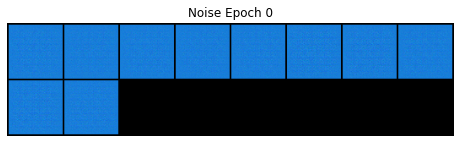

In [7]:
import matplotlib.pyplot as plt

# Create a new figure with a specific size
fig = plt.figure(figsize=(8,8))

# Turn off the axis
plt.axis("off")

# Set the title of the figure
plt.title('Noise Epoch 0')

# Create a list of images from the first element of fakeimg_list
# Each image is transposed from (channels, height, width) to (height, width, channels)
# The images are also set to be animated
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list[0:1]]

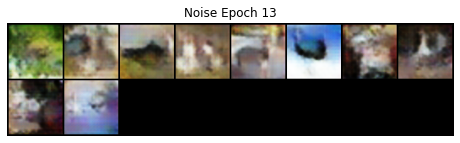

In [12]:
# Select the first 50 images from the fakeimg_list
tr = fakeimg_list[0:50]

# Create a new figure with a specific size
fig = plt.figure(figsize=(8,8))

# Turn off the axis
plt.axis("off")

# Set the title of the figure
plt.title('Noise Epoch 13')

# Create a list of images from the selected images in 'tr'
# Each image is transposed from (channels, height, width) to (height, width, channels)
# The images are also set to be animated
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in tr]

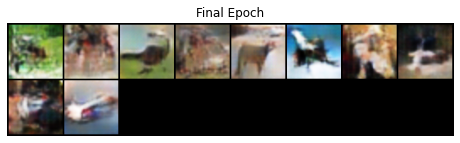

In [9]:
import matplotlib.pyplot as plt

# Create a new figure with a specific size
fig = plt.figure(figsize=(8,8))

# Turn off the axis
plt.axis("off")

# Set the title of the figure
plt.title('Final Epoch')

# Create a list of images from the fakeimg_list
# Each image is transposed from (channels, height, width) to (height, width, channels)
# The images are also set to be animated
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list]

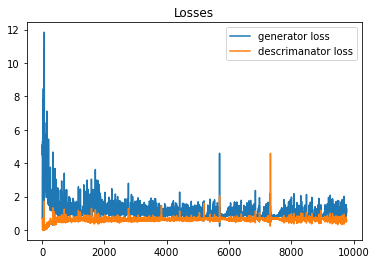

In [10]:
# Set the title of the plot
plt.title('Losses')

# Plot the generator loss
plt.plot(loss_ge,label = "generator loss")

# Plot the discriminator loss
plt.plot(loss_de,label = "descrimanator loss")

# Add a legend to the plot
plt.legend()